In [ ]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import pathlib
import seaborn as sns
from sklearn.metrics import classification_report
from src.data.dataset_loader import load_distracted_driver_detection_list, load_dataset_image_label
from src.data.image_label_loader import ImageLabelLoader
from src.evaluation import metrics
from src.utils.data_util import get_paths, sample_dataset
from src.preprocessing.image import hog_feature, color_histogram_hsv
from src.preprocessing.standardizer import Standardizer
from src.preprocessing.features_extractor import extract_features
from src.visualization.history_plotter import plot_loss_acc_history_epoch
from src.visualization.weights_visualization import visualize_weights
from src.classifiers.fc_net import FullyConnectedNet
from src.solver.solver import Solver

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = pathlib.Path("dataset/raw/imgs/train") # Train directory

X_train_filenames, X_val_filenames, y_train_labels, y_val_labels = load_distracted_driver_detection_list(val_size=0.2, split_on_driver=True, random_state=12)
train_paths = get_paths(data_dir, X_train_filenames, y_train_labels)
val_paths = get_paths(data_dir, X_val_filenames, y_val_labels)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

num_train = len(train_paths)
num_val = len(val_paths)
num_classes = len(class_names)

print(f'Training set size: {num_train}')
print(f'Validation set size: {num_val}')
print(f'Number of classes: {num_classes}')

Training set size: 17761
Validation set size: 4663
Number of classes: 10


In [3]:
def wrap_features(image, label):
    image = tf.numpy_function(features, [image], tf.float32)
    return image, label

def features(image):
    num_color_bins = 20 # Number of bins in the color histogram
    feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
    image = extract_features(image, feature_fns, verbose=True)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    return image

def preprocess(X_batch, y_batch):
    X_batch = standardizer.transform(X_batch) # Standardize
    return X_batch, y_batch

In [4]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del train_dset
   del val_dset
   print('Clear previously loaded data.')
except:
   pass

CPU = '/cpu:0'
GPU = '/device:GPU:0'

BATCH_SIZE = 128
IMG_SHAPE = (64, 64, 3)
loader = ImageLabelLoader(class_names, img_shape=IMG_SHAPE)
standardizer = Standardizer()

# Force image load and preprocessing with specific device
with tf.device(CPU):
    # Train dataset input pipeline
    train_dset = tf.data.Dataset.from_tensor_slices(train_paths)
    train_dset = train_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Load from path to image, label
    train_dset = train_dset.map(wrap_features, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Extract image features
    train_dset = train_dset.cache()
    train_dset = train_dset.shuffle(buffer_size=num_train, reshuffle_each_iteration=True)
    train_dset = train_dset.batch(BATCH_SIZE, drop_remainder=False)
    standardizer.fit(train_dset) # Fit mean and std to train set
    train_dset = train_dset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dset = train_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # Validation dataset input pipeline
    val_dset = tf.data.Dataset.from_tensor_slices(val_paths)
    val_dset = val_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.map(wrap_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.batch(BATCH_SIZE, drop_remainder=False)
    val_dset = val_dset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.cache()
    val_dset = val_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
img_batch, _ = next(iter(train_dset))
input_dim = img_batch.shape[1]
HIDDEN_DIM = [128]

learning_rates = [1e-3, 1e-4, 1e-5]
lr_decays = [0.95, 0.85]
weight_scales = [1e-3, 1e-4, 1e-2]
reg_strengths = [0.5, 0.25, 1e-2]

best_val =-1
best_solver = None

# permute over hyperparameters
grid_search = [(learning_rate, lr_decay, weight_scale, reg_strength) \
                for learning_rate in learning_rates \
                for lr_decay in lr_decays \
                for weight_scale in weight_scales \
                for reg_strength in reg_strengths \
                ]

for learning_rate, lr_decay, weight_scale, reg_strength in grid_search:
    model = FullyConnectedNet(HIDDEN_DIM, input_dim, num_classes, weight_scale=weight_scale, reg=reg_strength)
    solver = Solver(model, train_dset, val_dset,
                    update_rule='adam',
                    optim_config={
                        'learning_rate': learning_rate
                    },
                    lr_decay=lr_decay,
                    num_epochs=5,
                    verbose=False)

    solver.train()

    train_loss, train_acc = solver.evaluate(train_dset)
    val_loss, val_acc = solver.evaluate(val_dset)
    if val_acc >= best_val:
        best_val = val_acc
        best_solver = solver

    print('(learning_rate %e - lr_decay %e - weight_scale %e - reg_strength %e - train_acc %f -  val_acc %f)' % (learning_rate, lr_decay, weight_scale, reg_strength, train_acc, val_acc))
    print("===============================================")

In [8]:
img_batch, _ = next(iter(train_dset))
input_dim = img_batch.shape[1]
HIDDEN_DIM = [128]

model = FullyConnectedNet(HIDDEN_DIM, input_dim, num_classes, weight_scale=1e-3, reg=1e-2)
solver = Solver(model, train_dset, val_dset,
                update_rule='adam',
                optim_config={
                    'learning_rate': 1e-3
                },
                lr_decay=0.95,
                num_epochs=20,
                verbose=True)

solver.train()

Epoch 1/20
139/139 - loss: 1.1807 - accuracy: 0.7628 - val_loss: 0.3720 - val_accuracy: 0.7225
Epoch 2/20
139/139 - loss: 0.4685 - accuracy: 0.9801 - val_loss: 0.3320 - val_accuracy: 0.7667
Epoch 3/20
139/139 - loss: 0.3969 - accuracy: 0.9887 - val_loss: 0.3084 - val_accuracy: 0.7714
Epoch 4/20
139/139 - loss: 0.3729 - accuracy: 0.9886 - val_loss: 0.3255 - val_accuracy: 0.7504
Epoch 5/20
139/139 - loss: 0.3594 - accuracy: 0.9909 - val_loss: 0.4020 - val_accuracy: 0.7585
Epoch 6/20
139/139 - loss: 0.3507 - accuracy: 0.9922 - val_loss: 0.3292 - val_accuracy: 0.7722
Epoch 7/20
139/139 - loss: 0.3436 - accuracy: 0.9931 - val_loss: 0.4472 - val_accuracy: 0.7598
Epoch 8/20
139/139 - loss: 0.3416 - accuracy: 0.9927 - val_loss: 0.3326 - val_accuracy: 0.7630
Epoch 9/20
139/139 - loss: 0.3364 - accuracy: 0.9940 - val_loss: 0.3239 - val_accuracy: 0.7547
Epoch 10/20
139/139 - loss: 0.3333 - accuracy: 0.9942 - val_loss: 0.3904 - val_accuracy: 0.7540
Epoch 11/20
139/139 - loss: 0.3304 - accuracy: 0.

In [ ]:
plot_loss_acc_history_epoch(solver.loss_history, solver.val_loss_history, solver.accuracy_history, solver.val_accuracy_history)

Log Loss: 0.7216261263034796
Val Accuracy: 0.7722496247051255
Confusion Matrix:
[[351.  26.   1.  72.   2.   0.   0.   1.   0.  10.]
 [ 11. 363.  18.  41.   1.   0.   3.  25.   0.   8.]
 [ 37.  52. 371.   3.   6.   7.  16.   2.   4.   1.]
 [ 65.  47.   0. 363.   1.   1.   0.   0.   0.  13.]
 [ 54.   8.   0.  50. 374.   1.   0.   0.   0.   9.]
 [  9.  10.   0.   3.   6. 470.   0.   0.   6.   1.]
 [  3.  50.   9.   5.  11.   0. 398.   0.   7.   0.]
 [  2.   0.   1.   1.   2.   0.   3. 387.   0.   4.]
 [ 28.  15.   7.  19.   5.   0.   6.  12. 308.   4.]
 [ 28.   0.   1.  60.  40.  16.   1.   1.  90. 216.]]
Confusion Matrix Heatmap:


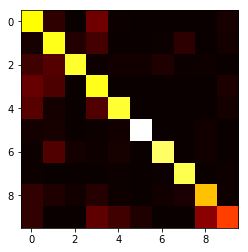

In [10]:
y_true = []
y_pred = []
y_scores = []
for _,(X_batch, y_batch) in enumerate(val_dset.as_numpy_iterator()):
    y_true.append(y_batch)

    scores = model.predict(X_batch)
    y_scores.append(scores)
    prediction = np.argmax(scores, axis=1)
    y_pred.append(prediction)
    
y_true = np.hstack(y_true)
y_pred = np.hstack(y_pred)
y_scores = np.concatenate(y_scores)

# Log Loss Score
log_loss = metrics.log_loss(y_true, y_scores)
print(f"Log Loss: {log_loss}")

# Validation Accuracy
val_acc = metrics.accuracy(y_true, y_pred)
print(f"Val Accuracy: {val_acc}")

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Heatmap of the confusion matrix
print("Confusion Matrix Heatmap:")
plt.imshow(conf_matrix, cmap='hot', interpolation='nearest')
plt.show()

Log Loss: 0.7216261263034796
Accuracy: 0.7722496247051255


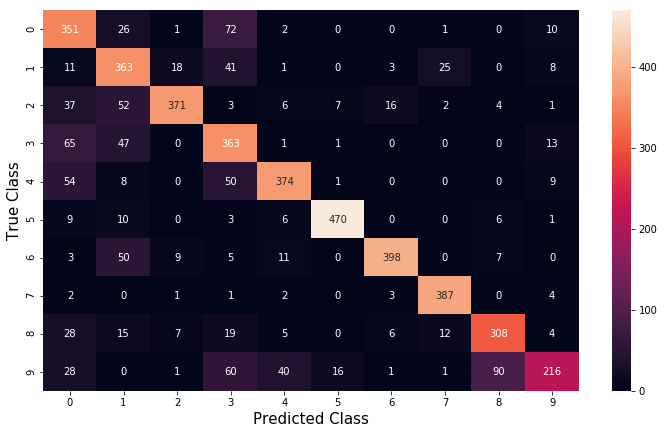

In [13]:
y_true = []
y_pred = []
y_scores = []
for _,(X_batch, y_batch) in enumerate(val_dset.as_numpy_iterator()):
    y_true.append(y_batch)

    scores = model.predict(X_batch)
    y_scores.append(scores)
    prediction = np.argmax(scores, axis=1)
    y_pred.append(prediction)
    
y_true = np.hstack(y_true)
y_pred = np.hstack(y_pred)
y_scores = np.concatenate(y_scores)

# Log Loss Score
log_loss = metrics.log_loss(y_true, y_scores)
print(f"Log Loss: {log_loss}")

# Validation Accuracy
val_acc = metrics.accuracy(y_true, y_pred)
print(f"Accuracy: {val_acc}")

# Heat Map
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='g')
heatmap.set_xlabel("Predicted Class", fontsize = 15)
heatmap.set_ylabel("True Class", fontsize = 15)
plt.show()

In [14]:
class_desc = ['Safe Driving', 'Texting - Right', 'Talking on the phone - Right', 
'Texting - Left', 'Talking on the phone - Left', 'Operating The Radio', 
'Drinking', 'Reaching Behind', 'Hair and Makeup', 'Talking to Passanger']

print(classification_report(y_true, y_pred, target_names=class_desc))

                              precision    recall  f1-score   support

                Safe Driving       0.60      0.76      0.67       463
             Texting - Right       0.64      0.77      0.70       470
Talking on the phone - Right       0.91      0.74      0.82       499
              Texting - Left       0.59      0.74      0.66       490
 Talking on the phone - Left       0.83      0.75      0.79       496
         Operating The Radio       0.95      0.93      0.94       505
                    Drinking       0.93      0.82      0.87       483
             Reaching Behind       0.90      0.97      0.93       400
             Hair and Makeup       0.74      0.76      0.75       404
        Talking to Passanger       0.81      0.48      0.60       453

                    accuracy                           0.77      4663
                   macro avg       0.79      0.77      0.77      4663
                weighted avg       0.79      0.77      0.77      4663

